In [10]:
import torch
from torch import nn
from d2l import torch as d2l
from torchvision import transforms
import torchvision

In [11]:
# .view() 是 PyTorch 张量的一个方法，它的作用是改变张量的形状，同时不改变其底层数据。
# 占位符 -1 : PyTorch 会自动计算这个维度的大小
"""
例如，如果你的原始张量 x 有 1000 个元素，
并且你指定了其他维度为 1 * 28 * 28 = 784，
那么 -1 就会被自动计算为 1000 / 784（如果不能整除就会报错）
"""

# Flatten()保持第一个维度数不变，后面全部拉平
X_test = torch.rand(size=(2, 4, 2, 5), dtype = torch.float32)
print(X_test.shape)
flat = nn.Flatten()
X_test = flat(X_test)
print(X_test.shape)

torch.Size([2, 4, 2, 5])
torch.Size([2, 40])


In [12]:
class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)
    
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [13]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    # layer.__class__：这会获取 layer 对象所属的类
    # .__name__：，用于获取类的名称字符串
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


# LeNet在Fashion-MNIST数据集上的表现

In [ ]:
# 自定义数据加载函数，提高性能
def load_data_fashion_mnist(batch_size, resize=None, pin_memory=False):
    """Download the Fashion-MNIST dataset and then load it into memory.

    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                        num_workers=4, pin_memory=pin_memory),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                        num_workers=4, pin_memory=pin_memory))

In [20]:

def load_data_fashion_mnist_without_batch(resize=None, pin_memory=False):
    """Download the Fashion-MNIST dataset and then load it into memory.

    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    train_size = len(mnist_train)
    test_size = len(mnist_test)
    return (torch.utils.data.DataLoader(mnist_train, train_size, shuffle=True,
                                        num_workers=4, pin_memory=pin_memory),
            torch.utils.data.DataLoader(mnist_test, test_size, shuffle=False,
                                        num_workers=4, pin_memory=pin_memory))

In [ ]:

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size, pin_memory=True)   
len(train_iter) 

1

In [23]:
"""
在深度学习中，模型在训练阶段和推理/评估阶段的行为通常是不同的。
有些层和操作在训练时有特定的行为，但在评估时需要关闭或改变其行为，以确保结果的稳定性和可复现性。
如：关闭Dropout、改变BatchNorm（BatchNorm 层不再使用当前小批量的均值和方差，而是使用在训练阶段累积的全局均值和方差来进行归一化）
"""
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval() # 将神经网络模型设置为评估（evaluation）模式
        if not device:
            device = next(iter(net.parameters())).device # 数据存哪就在哪跑
    metric = d2l.Accumulator(2)  # 做一个累加器
    for X,y in data_iter:
        if isinstance(X, list): # list需要分多次移完
            X = [x.to(device) for x in X]
        else: # tensor 可以一次移完
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X),y),y.numel()) # y.numel() 为y元素个数 
    return metric[0]/metric[1]


In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # _表示改变变量
    net.apply(init_weights)
    print("training on", device)
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.01, )
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs],
                            legend=["train_loss", "train_acc", "test_acc"])
    timer, num_batches = d2l.Timer(), len(train_iter) # 计时器，批数

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train() # * 将神经网络模型设置为训练（training）模式

        for i,(X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

        with torch.no_grad():
            # 所有批次的累计损失，正确数，批量数
            metric.add(l * X.shape[0], d2l.accuracy(y_hat,y),X.shape[0])

        timer.stop()
        train_l = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]

        print(f'epoch:{epoch}, train_loss:{train_l:.3f},train_acc:{train_acc:.3f}')

        # 定时作画，但保证每轮至少最后一批时会画一次
        if(i+1) % (num_batches//5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i+1) / num_batches,
                        (train_l, train_acc, None))
                
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    print(f'loss {train_l:.3f},train acc {train_acc:.3f},'
         f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec'
         f'on{str(device)}')

epoch:5, train_loss:2.454,train_acc:0.100


KeyboardInterrupt: 

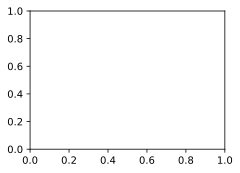

In [ ]:
# 训练和评估LeNet-5模型
lr, num_epochs = 0.9, 50  # Adam通常用较小的学习率（如0.001）
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
d2l.try_gpu()

device(type='cuda', index=0)